## Assignment 1
By Jing Wang, Alexander Moshchev, Dushyant, Suchitra Nayak, Yiting


In [1]:

import matplotlib.pyplot as plt
import numpy as np

from sklearn.random_projection import SparseRandomProjection
from sklearn.model_selection import train_test_split
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn import metrics
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore') # works
#warnings.filterwarnings(action='once') #does not work

## Random projections

Based on the program developed in the lecture (SparseRandomProjections), analyze 2 databases of your choice (but not exactly the same digits data as in the lecture) using random projections. Study the accuracy (or a score of your choice that makes most sense for your data) as a function of the number of dimensions / features that
survived the random projection.  
  
Try to avoid a zick-zack curve below or around the baseline accuracy curve as your final result for both datasets. At least for one dataset the score is expected to be a smooth-ish curve as a function of the kept number of
features. Provide a take-home statement and explain every step. You may find that data embedded in Euclidian spaces (such as digits) may be more appropriate than data for which Euclidian distances are not excellent distance measures

In [2]:
def compare_SparseRandomProjection(data, target, dimension):
    
    #first get the train test split
    split = train_test_split(data, 
                             target, 
                             test_size = 0.2, 
                             random_state = 11
                             )
    (trainData, testData, trainTarget, testTarget) = split
    
    #calculate theorical Johnson Lindenstrauss K
    Eps = 0.2
    k = johnson_lindenstrauss_min_dim(dimension,eps=Eps)
    
    #calculate orignal accurcay with 10 times average.
    baseline = np.empty([11])
    for i in range(0,10):
        model = LinearSVC()
        model.fit(trainData, trainTarget)
        baseline[i] = metrics.accuracy_score(model.predict(testData), testTarget)
    baseline_avg = baseline[:].mean()
    
    #get 30 with logspace to avoid recalculate in high dim
    dims = np.int32(np.logspace(np.log10(2), np.log10(dimension), 20))

    #calculate each dim in dims use Sparse Random Projection
    
    #run it in realizations 25
    realizations = 25
    accuracies =np.empty([realizations, dimension+1])
    average_acc = []
    # Loop over the projection sizes, k
    for dim in dims:
        
        # average over realizations
        for i in range(realizations):
            # Create random projection
            sp = SparseRandomProjection(n_components = dim)
            X = sp.fit_transform(trainData)
    
            # Train classifier of your choice on the sparse random projection
            model = LinearSVC()
            model.fit(X, trainTarget)
    
            # Evaluate model and update accuracies
            test = sp.transform(testData)
            accuracies[i,dim]=(metrics.accuracy_score(model.predict(test), testTarget))

        average_acc.append(accuracies[:,dim].mean())   

    #plot the result
    plt.figure()
    plt.xlabel("# of dimensions k")
    plt.ylabel("AVG Accuracy")
    plt.xlim([2, dims[-1]])
    plt.ylim([0, 1])

    # Plot baseline and random projection accuracies
    plt.plot(dims, [baseline_avg] * len(average_acc), 
             color = "r", 
             label = "Orignal dimenson Average ACC"
             )
    plt.plot(dims, average_acc, label = 'Average ACC')
    """    
    plt.plot([k] * len(average_acc), 
             np.linspace(0,1,len(average_acc)), 
             label = 'John. Lind. K =' + str(k) +'eps = 0.2'
             )"""
    plt.legend()
    plt.show()
    
    return   
    

## Dataset from Openml with project name arcene

ARCENE's task is to distinguish cancer versus normal patterns from mass-spectrometric data. This is a two-class classification problem with continuous input variables.

It has 10001 features with 200 instances and 2 classes.

Source: UCI

linke : https://www.openml.org/search?type=data&sort=qualities.NumberOfFeatures&status=active&id=1458


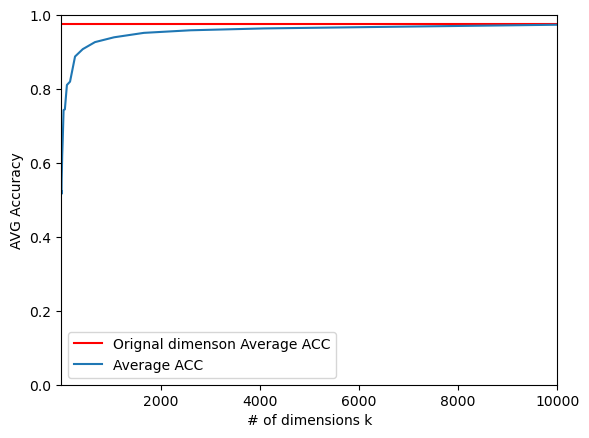

In [3]:
from sklearn.datasets import fetch_openml
arcene = fetch_openml(name='arcene')
compare_SparseRandomProjection(arcene.data, arcene.target, 10001)

## Dataset from Openml with project name Mnist 784

The MNIST database of handwritten digits with 784 features,
It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

It has 784 features with 70000 instances and 10 classes.

https://www.openml.org/search?type=data&sort=runs&id=554&status=active

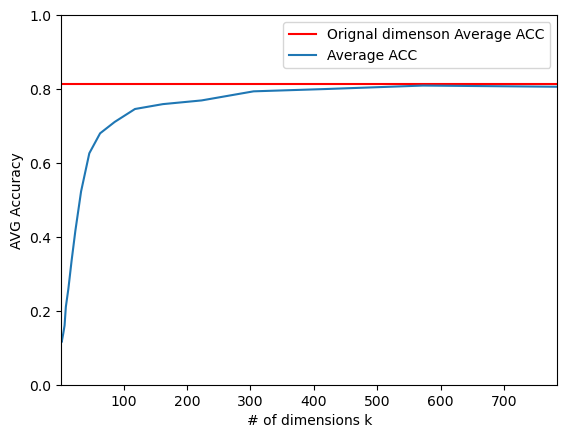

In [4]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load mnist 784
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

# get the data and target
raw_data = mnist.data
raw_target = mnist.target

# prepare a empty index list
indices = []

# for each class find 100 instances
for i in range(10):  
    class_indices = np.where(raw_target == str(i))[0]
    if len(class_indices) >= 100:
        selected_indices = np.random.choice(class_indices, 100, replace=False)
        indices.extend(selected_indices)


#use indices reduce the instances from 70000 to 1000
mnist_data= raw_data.iloc[indices]
mnist_target = raw_target.iloc[indices]
compare_SparseRandomProjection(mnist_data, mnist_target ,784)